In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR, OneCycleLR
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize
from torchvision.ops import nms
import tensorflow as tf
import tensorflow_datasets as tfds
from torchviz import make_dot
from torchinfo import summary
from torch.autograd import Variable
import pandas as pd
import cv2

import shutil
import re
import gc
import io, json, os, math
import six
import math
import pickle
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from PIL import Image, ImageFile, ImageDraw
import ray
from IPython.display import display

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# Loss 및 maxrix 정의
#=================================================================================================================================================================================
class RetinaNetBoxLoss(nn.Module):
    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__()
        self._delta = delta

    def forward(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = torch.abs(difference)
        squared_difference = difference ** 2
        loss = torch.where(
            absolute_difference < self._delta,
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return torch.sum(loss, dim=-1)

class RetinaNetClassificationLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__()
        self._alpha = alpha
        self._gamma = gamma

    def forward(self, y_true, y_pred):
        cross_entropy = F.binary_cross_entropy_with_logits(y_pred, y_true, reduction='none')
        probs = torch.sigmoid(y_pred)
        alpha = torch.where(y_true == 1.0, self._alpha, 1.0 - self._alpha)
        pt = torch.where(y_true == 1.0, probs, 1 - probs)
        loss = alpha * torch.pow(1.0 - pt, self._gamma) * cross_entropy
        return torch.sum(loss, dim=-1)

class RetinaNetLoss(nn.Module):
    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__()
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def forward(self, y_true, y_pred):
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = F.one_hot(y_true[:, :, 4].long(), num_classes=self._num_classes).float()
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = (y_true[:, :, 4] > -1.0).float()
        ignore_mask = (y_true[:, :, 4] == -2.0).float()

        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)

        clf_loss = torch.where(ignore_mask == 1.0, torch.zeros_like(clf_loss), clf_loss)
        box_loss = torch.where(positive_mask == 1.0, box_loss, torch.zeros_like(box_loss))

        normalizer = torch.sum(positive_mask, dim=-1)
        clf_loss = torch.div(torch.sum(clf_loss, dim=-1), normalizer)
        box_loss = torch.div(torch.sum(box_loss, dim=-1), normalizer)

        loss = clf_loss + box_loss
        return loss

def _intersect(box_a, box_b):
    A = box_a.shape[0]
    B = box_b.shape[0]

    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))

    inter = torch.clamp((max_xy - min_xy), min=0)

    return inter[:, :, 0] * inter[:, :, 1]

def _jaccard(box_a, box_b):
    inter = _intersect(box_a, box_b)

    area_a = ((box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1])).unsqueeze(1).expand_as(inter)
    area_b = ((box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1])).unsqueeze(0).expand_as(inter)

    union = area_a + area_b - inter

    return inter / union

def Accuracy_function(predicted, labels):
    acc = (predicted == labels).float().mean()
    return acc

def Accuracy_function_mixup(logits, label_a, label_b, ratio):
    _, top_indices = logits.topk(2, dim=1)
    hit_a = (top_indices == label_a.unsqueeze(1)).any(dim=1).float()
    hit_b = (top_indices == label_b.unsqueeze(1)).any(dim=1).float()

    if not torch.is_tensor(ratio):
        ratio=float(ratio)
    
    acc = ((1.0 - ratio) * hit_a +  ratio* hit_b).float().mean()
    
    return acc

def get_iou(bbox1, bbox2):
    # bbox 중 하나라도 None이면 IoU 0.0
    if bbox1 is None or bbox2 is None:
        return 0.0

    x_min1, y_min1, x_max1, y_max1 = bbox1
    x_min2, y_min2, x_max2, y_max2 = bbox2

    # 두 bbox의 교집합 영역 좌표 계산
    x_min_inter = max(x_min1, x_min2)
    y_min_inter = max(y_min1, y_min2)
    x_max_inter = min(x_max1, x_max2)
    y_max_inter = min(y_max1, y_max2)

    # 교집합의 너비와 높이 (음수가 되지 않도록)
    inter_width = max(0, x_max_inter - x_min_inter)
    inter_height = max(0, y_max_inter - y_min_inter)
    inter_area = inter_width * inter_height

    # 각 bbox의 면적 계산
    area1 = (x_max1 - x_min1) * (y_max1 - y_min1)
    area2 = (x_max2 - x_min2) * (y_max2 - y_min2)

    # 합집합 면적: A ∪ B = A + B - A ∩ B
    union_area = area1 + area2 - inter_area
    if union_area <= 0:
        return 0.0

    iou = inter_area / union_area
    return iou

In [4]:
# Transforms 설계
#========================================================================================================================================================#
def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        size=(224, 224),
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
                Resize(
                    width=224,
                    height=224
                    )
                ])

In [5]:
#model 설계
#========================================================================================================================================================#
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, filters, stride=1, downsample=False):
        super(BottleneckBlock, self).__init__()
        self.downsample = downsample
        # 만약 downsample이라면 identity branch에 1x1 conv 적용하여 채널 수와 spatial size 조정
        if self.downsample:
            self.downsample_conv = nn.Conv2d(in_channels, filters, kernel_size=1, stride=stride, bias=False)

        # main branch
        self.bn1 = nn.BatchNorm2d(in_channels, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, filters // 2, kernel_size=1, stride=1, padding=0, bias=False)

        self.bn2 = nn.BatchNorm2d(filters // 2, momentum=0.9)
        # kernel_size=3, padding=1로 'same' padding 효과
        self.conv2 = nn.Conv2d(filters // 2, filters // 2, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn3 = nn.BatchNorm2d(filters // 2, momentum=0.9)
        self.conv3 = nn.Conv2d(filters // 2, filters, kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample_conv(x)

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        out += identity
        return out

class HourglassModule(nn.Module):
    def __init__(self, order, filters, num_residual):
        super(HourglassModule, self).__init__()
        self.order = order

        # Up branch: BottleneckBlock 1회 + num_residual회 반복
        self.up1_0 = BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
        self.up1_blocks = nn.Sequential(*[
            BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
            for _ in range(num_residual)
        ])

        # Low branch: MaxPool + num_residual BottleneckBlock
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.low1_blocks = nn.Sequential(*[
            BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
            for _ in range(num_residual)
        ])

        # Recursive hourglass or additional BottleneckBlocks
        if order > 1:
            self.low2 = HourglassModule(order - 1, filters, num_residual)
        else:
            self.low2_blocks = nn.Sequential(*[
                BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
                for _ in range(num_residual)
            ])

        # 후처리 BottleneckBlock 반복
        self.low3_blocks = nn.Sequential(*[
            BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
            for _ in range(num_residual)
        ])

        # UpSampling (최근접 보간법)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        # up branch
        up1 = self.up1_0(x)
        up1 = self.up1_blocks(up1)

        # low branch
        low1 = self.pool(x)
        low1 = self.low1_blocks(low1)
        if self.order > 1:
            low2 = self.low2(low1)
        else:
            low2 = self.low2_blocks(low1)
        low3 = self.low3_blocks(low2)
        up2 = self.upsample(low3)

        return up2 + up1

class LinearLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LinearLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)

        # He (Kaiming) 초기화 적용
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class StackedHourglassNetwork(nn.Module):
    def __init__(self, input_shape=(256, 256, 3), num_stack=4, num_residual=1, num_heatmap=16):
        super(StackedHourglassNetwork, self).__init__()
        self.num_stack = num_stack

        in_channels = input_shape[2]  # 3
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)

        # Bottleneck blocks 초기화
        # BottleneckBlock의 첫번째 호출: 64 → 128, downsample=True
        self.bottleneck1 = BottleneckBlock(in_channels=64, filters=128, stride=1, downsample=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 두 번째: 128 → 128, downsample=False
        self.bottleneck2 = BottleneckBlock(in_channels=128, filters=128, stride=1, downsample=False)
        # 세 번째: 128 → 256, downsample=True
        self.bottleneck3 = BottleneckBlock(in_channels=128, filters=256, stride=1, downsample=True)

        # 스택 구성 요소들
        self.hourglass_modules = nn.ModuleList()
        self.residual_modules = nn.ModuleList()  # hourglass 후 residual block들 (num_residual회)
        self.linear_layers = nn.ModuleList()
        self.heatmap_convs = nn.ModuleList()
        # 마지막 스택을 제외한 중간 피쳐 결합용 1x1 conv
        self.intermediate_convs = nn.ModuleList()
        self.intermediate_outs = nn.ModuleList()

        for i in range(num_stack):
            # order=4인 hourglass 모듈 (앞에서 정의한 HourglassModule 사용)
            self.hourglass_modules.append(HourglassModule(order=4, filters=256, num_residual=num_residual))
            # hourglass 후 residual block들
            self.residual_modules.append(nn.Sequential(*[
                BottleneckBlock(in_channels=256, filters=256, stride=1, downsample=False)
                for _ in range(num_residual)
            ]))
            # Linear layer: 1x1 conv + BN + ReLU (앞에서 정의한 LinearLayer 사용)
            self.linear_layers.append(LinearLayer(in_channels=256, out_channels=256))
            # 최종 heatmap을 생성하는 1x1 conv
            self.heatmap_convs.append(nn.Conv2d(256, num_heatmap, kernel_size=1, stride=1, padding=0))

            if i < num_stack - 1:
                self.intermediate_convs.append(nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0))
                self.intermediate_outs.append(nn.Conv2d(num_heatmap, 256, kernel_size=1, stride=1, padding=0))

    def forward(self, x):
        # x: (B, 3, H, W)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.bottleneck1(x)
        x = self.pool(x)
        x = self.bottleneck2(x)
        x = self.bottleneck3(x)

        outputs = []
        for i in range(self.num_stack):
            hg = self.hourglass_modules[i](x)
            res = self.residual_modules[i](hg)
            lin = self.linear_layers[i](res)
            heatmap = self.heatmap_convs[i](lin)
            outputs.append(heatmap)

            if i < self.num_stack - 1:
                inter1 = self.intermediate_convs[i](lin)
                inter2 = self.intermediate_outs[i](heatmap)
                x = inter1 + inter2  # 다음 스택의 입력으로 사용

        return outputs

class SimpleBaseline(nn.Module):
    def __init__(
        self,
        input_shape=(256, 256, 3),
        num_stack=1,
        num_residual=1,
        num_heatmap=16,
    ):
        super().__init__()
        self.num_stack = num_stack

        in_channels = input_shape[2]

        self.conv1 = nn.Conv2d(
            in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)
        # 256x256 -> 128x128 (conv1) -> 64x64 (maxpool)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 1) layer1: 64 -> 64, stride=1  (C=64, H=W=64)
        self.layer1 = self._make_layer(
            in_channels=64,
            filters=64,
            blocks=2,
            stride=1,
        )

        # 2) layer2: 64 -> 128, stride=2 (C=128, H=W=32)
        self.layer2 = self._make_layer(
            in_channels=64,
            filters=128,
            blocks=2,
            stride=2,
        )

        # 3) layer3: 128 -> 256, stride=2 (C=256, H=W=16)
        self.layer3 = self._make_layer(
            in_channels=128,
            filters=256,
            blocks=2,
            stride=2,
        )

        # 4) layer4: 256 -> 256, stride=2 (C=256, H=W=8)
        self.layer4 = self._make_layer(
            in_channels=256,
            filters=256,
            blocks=2,
            stride=2,
        )

        backbone_out_channels = 256
        
        #   8x8 -> 16x16 -> 32x32 -> 64x64
        self.deconv_layers = self._make_deconv_layer(
            num_layers=3,
            num_filters=[256, 256, 256],
            num_kernels=[4, 4, 4],
            in_channels=backbone_out_channels,
        )

        # stack 개수만큼 마지막 1x1 conv head 준비
        # (각 stack마다 다른 파라미터를 가지는 heatmap head)
        self.heads = nn.ModuleList([
            nn.Conv2d(
                in_channels=256,
                out_channels=num_heatmap,
                kernel_size=1,
                stride=1,
                padding=0,
            )
            for _ in range(num_stack)
        ])

    # BottleneckBlock을 쌓아서 layer 만들기
    def _make_layer(self, in_channels, filters, blocks, stride=1):
        """
        - 첫 block에서만 stride/downsample 적용
        - 이후 block은 stride=1, downsample=False
        """
        layers = []

        # downsample이 필요한지 판단 (채널 수 또는 stride가 달라질 때)
        downsample = (stride != 1) or (in_channels != filters)

        # 첫 block
        layers.append(
            BottleneckBlock(
                in_channels=in_channels,
                filters=filters,
                stride=stride,
                downsample=downsample,
            )
        )

        # 나머지 block들
        for _ in range(1, blocks):
            layers.append(
                BottleneckBlock(
                    in_channels=filters,
                    filters=filters,
                    stride=1,
                    downsample=False,
                )
            )

        return nn.Sequential(*layers)

    # Deconv layer 쌓기 (ConvTranspose2d + BN + ReLU)
    def _make_deconv_layer(
        self,
        num_layers,
        num_filters,
        num_kernels,
        in_channels,
    ):
        """
        ConvTranspose2d + BN + ReLU 를 num_layers번 반복해서 쌓음.
        """
        assert num_layers == len(num_filters) == len(num_kernels)

        layers = []
        in_ch = in_channels

        for i in range(num_layers):
            out_ch = num_filters[i]
            kernel = num_kernels[i]

            # kernel=4일 때 
            # stride=2, padding=1, output_padding=0  -> 해상도 2배
            if kernel == 4:
                padding = 1
                output_padding = 0
            elif kernel == 3:
                padding = 1
                output_padding = 1
            else:  # kernel == 2 같은 경우
                padding = 0
                output_padding = 0

            layers.append(
                nn.ConvTranspose2d(
                    in_channels=in_ch,
                    out_channels=out_ch,
                    kernel_size=kernel,
                    stride=2,
                    padding=padding,
                    output_padding=output_padding,
                    bias=False,
                )
            )
            layers.append(nn.BatchNorm2d(out_ch, momentum=0.9))
            layers.append(nn.ReLU(inplace=True))

            in_ch = out_ch

        return nn.Sequential(*layers)

    def forward(self, x):
        """
        x: (B, 3, 256, 256)
        출력:
          outputs: list 길이 = num_stack
                   각 요소 shape = (B, num_heatmap, 64, 64)
        -> StackedHourglassNetwork의 outputs와 구조/shape 호환
        """
        # Stem
        x = self.conv1(x)      # (B, 64, 128, 128)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)    # (B, 64, 64, 64)

        # Backbone
        x = self.layer1(x)     # (B, 64, 64, 64)
        x = self.layer2(x)     # (B, 128, 32, 32)
        x = self.layer3(x)     # (B, 256, 16, 16)
        x = self.layer4(x)     # (B, 256,  8,  8)

        # Deconv head: 8 -> 16 -> 32 -> 64
        x = self.deconv_layers(x)  # (B, 256, 64, 64)

        # StackedHourglassNetwork와 맞추기 위해
        # 여러 stack의 heatmap을 outputs 리스트에 담아서 반환
        outputs = []
        for head in self.heads:
            heatmap = head(x)  # (B, num_heatmap, 64, 64)
            outputs.append(heatmap)

        return outputs

In [6]:
# data labeling 함수
#=================================================================================================================================================================================
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

def generate_ptexample(anno):
    filename = anno['filename']
    filepath = anno['filepath']

    # 이미지 파일 읽기
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    # JPEG 형식 및 RGB 모드가 아니면 변환
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [int(joint[0]) if joint[0] >= 0 else int(joint[0])
         for joint in anno['joints']]
    y = [int(joint[1]) if joint[1] >= 0 else int(joint[0])
         for joint in anno['joints']]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height': height,
        'image/width': width,
        'image/depth': depth,
        'image/object/parts/x': x,
        'image/object/parts/y': y,
        'image/object/center/x': c_x,
        'image/object/center/y': c_y,
        'image/object/scale': scale,
        'image/object/parts/v': v,
        'image/encoded': content,
        'image/filename': filename.encode()  # bytes로 저장
    }

    return feature

def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

@ray.remote
def build_single_ptrecord(chunk, path):
    print('start to build ptrecord for ' + path)

    with open(path, 'wb') as writer:
        for anno in chunk:
            ptexample = generate_ptexample(anno)
            pickle.dump(ptexample, writer)

    print('finished building ptrecord for ' + path)

def build_pt_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_ptrecord.remote(
            chunk, '{}/{}_{}_of_{}.ptrecords'.format(
                PT_RECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )
        ) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)


class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape      # (height, width, channels)
        self.heatmap_shape = heatmap_shape  # (height, width, num_heatmap)

    def __call__(self, example):
        features = self.parse_tfexample(example)
        # image 데이터를 다시 bytes로 디코딩 후 재로딩 (JPEG 형식)
        image = Image.open(io.BytesIO(features['image/encoded']))

        if self.is_train:
            # 0.1 ~ 0.3 사이의 random margin 생성
            random_margin = torch.empty(1).uniform_(0.1, 0.3).item()
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = image.resize((self.image_shape[1], self.image_shape[0]))
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = image.resize((self.image_shape[1], self.image_shape[0]))

        # 이미지 정규화: uint8 → [0,255] → [-1, 1]
        image_np = np.array(image).astype(np.float32)
        image_np = image_np / 127.5 - 1.0
        # 채널 우선순서로 변환: (H, W, C) -> (C, H, W)
        image_tensor = torch.from_numpy(image_np).permute(2, 0, 1)

        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image_tensor, heatmaps

    def parse_tfexample(self, example):
        """
        MPIIDataset에서 전달한 예제를 받아, Preprocessor가 처리할 수 있도록 features dict를 구성합니다.
        예제 형식: {'image': PIL.Image, 'annotation': anno}
        """
        annotation = example['annotation']
        # joints: list of [x, y]
        joints = annotation['joints']
        keypoint_x = [joint[0] for joint in joints]
        keypoint_y = [joint[1] for joint in joints]

        # joints_vis가 없으면 모든 관절이 가시적이라고 가정 (1)
        joints_vis = annotation.get('joints_vis', [1] * len(joints))

        features = {
            'image/encoded': self.image_to_bytes(example['image']),
            'image/object/parts/x': keypoint_x,
            'image/object/parts/y': keypoint_y,
            'image/object/parts/v': joints_vis,
            'image/object/center/x': annotation['center'][0],
            'image/object/center/y': annotation['center'][1],
            'image/object/scale': annotation['scale'],
        }
        return features

    def image_to_bytes(self, image):
        """
        PIL.Image 객체를 JPEG 인코딩된 bytes로 변환합니다.
        """
        buffer = io.BytesIO()
        image.save(buffer, format="JPEG")
        return buffer.getvalue()

    def crop_roi(self, image, features, margin=0.2):
        # image: PIL.Image, features: dict
        img_width, img_height = image.size  # PIL: (width, height)

        keypoint_x = torch.tensor(features['image/object/parts/x'], dtype=torch.int32)
        keypoint_y = torch.tensor(features['image/object/parts/y'], dtype=torch.int32)
        body_height = features['image/object/scale'] * 200.0

        # 유효한 keypoint (값 > 0)만 선택
        masked_keypoint_x = keypoint_x[keypoint_x > 0]
        masked_keypoint_y = keypoint_y[keypoint_y > 0]

        keypoint_xmin = int(masked_keypoint_x.min().item())
        keypoint_xmax = int(masked_keypoint_x.max().item())
        keypoint_ymin = int(masked_keypoint_y.min().item())
        keypoint_ymax = int(masked_keypoint_y.max().item())

        extra = int(body_height * margin)
        xmin = keypoint_xmin - extra
        xmax = keypoint_xmax + extra
        ymin = keypoint_ymin - extra
        ymax = keypoint_ymax + extra

        effective_xmin = max(xmin, 0)
        effective_ymin = max(ymin, 0)
        effective_xmax = min(xmax, img_width)
        effective_ymax = min(ymax, img_height)

        cropped_image = image.crop((effective_xmin, effective_ymin, effective_xmax, effective_ymax))

        new_width = effective_xmax - effective_xmin
        new_height = effective_ymax - effective_ymin

        effective_keypoint_x = (keypoint_x.float() - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y.float() - effective_ymin) / new_height

        return cropped_image, effective_keypoint_x, effective_keypoint_y

    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        heatmap = torch.zeros((height, width), dtype=torch.float32)

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
            return heatmap

        size = int(6 * sigma + 1)
        grid_range = torch.arange(0, size, dtype=torch.float32)
        x_grid, y_grid = torch.meshgrid(grid_range, grid_range, indexing='xy')
        center_x = size // 2
        center_y = size // 2

        gaussian_patch = torch.exp(-(((x_grid - center_x)**2 + (y_grid - center_y)**2) / (2 * sigma**2))) * scale

        patch_xmin = max(0, -xmin)
        patch_ymin = max(0, -ymin)
        patch_xmax = min(xmax, width) - xmin
        patch_ymax = min(ymax, height) - ymin

        heatmap_xmin = max(0, xmin)
        heatmap_ymin = max(0, ymin)
        heatmap_xmax = min(xmax, width)
        heatmap_ymax = min(ymax, height)

        heatmap[heatmap_ymin:heatmap_ymax, heatmap_xmin:heatmap_xmax] = \
            gaussian_patch[int(patch_ymin):int(patch_ymax), int(patch_xmin):int(patch_xmax)]

        return heatmap

    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        # heatmap_shape: (height, width, num_heatmap)
        v = torch.tensor(features['image/object/parts/v'], dtype=torch.float32)
        x = torch.round(keypoint_x * heatmap_shape[1]).to(torch.int32)  # width: heatmap_shape[1]
        y = torch.round(keypoint_y * heatmap_shape[0]).to(torch.int32)  # height: heatmap_shape[0]

        num_heatmap = heatmap_shape[2]
        heatmaps_list = []

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(
                height=heatmap_shape[0],
                width=heatmap_shape[1],
                y0=int(y[i].item()),
                x0=int(x[i].item()),
                visibility=int(v[i].item())
            )
            heatmaps_list.append(gaussian)

        # 스택 후, (num_heatmap, height, width) 형태로 반환
        heatmaps = torch.stack(heatmaps_list, dim=0)
        return heatmaps

In [7]:
# Dataset 설계
#=======================================================================================================================================================================
class MPIIDataset(Dataset):
    def __init__(self, annotation_file, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        # JSON 파일을 읽어 annotations 리스트 생성
        with open(annotation_file, 'r') as f:
            annotations = json.load(f)

        # 각 annotation을 파싱하여 리스트에 저장
        self.annotations = [parse_one_annotation(anno, image_dir) for anno in annotations]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        anno = self.annotations[idx]
        # 이미지 파일 경로로부터 이미지를 로드 (RGB 모드로 변환)
        image = Image.open(anno['filepath']).convert('RGB')

        # transform이 있으면 적용
        if self.transform:
            image, heatmaps = self.transform({'image': image, 'annotation': anno})
            return image, heatmaps
        else:
            # transform이 없으면 원본 이미지와 annotation dict 반환
            return image, anno

def create_dataloader(annotation_file, image_dir, batch_size, num_heatmap, num_workers=4,pin_memory=True, prefetch_factor=2, is_train=True, drop_last=False):
    """
    annotation_file: JSON 파일 경로 (예: train.json)
    image_dir: 이미지 파일들이 저장된 디렉토리 경로
    batch_size: 배치 크기
    num_heatmap: 생성할 heatmap 개수
    is_train: True이면 shuffle 적용
    """

    preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap),
        is_train=is_train
    )

    dataset = MPIIDataset(annotation_file=annotation_file, image_dir=image_dir, transform=preprocess)

    if num_workers is not None:
        # DataLoader 생성
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=is_train,
            num_workers=num_workers,
            pin_memory=pin_memory,
            drop_last=drop_last,
            prefetch_factor=prefetch_factor
        )
    else:
        # DataLoader 생성
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=is_train,
            drop_last=drop_last,
        )

    return dataloader

In [8]:
# 학습 함수
#=======================================================================================================================================================================
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 optimizer,
                 initial_learning_rate,
                 patience=10):
        """
        - model: 학습시킬 PyTorch 모델(nn.Module)
        - epochs: 전체 학습 epoch 수
        - global_batch_size: 전체 배치 크기 (loss 계산 시 사용)
        - initial_learning_rate: 초기 학습률
        """
        self.model = model
        self.epochs = epochs
        self.global_batch_size = global_batch_size

        # MSE loss를 reduction='none'으로 사용 (가중치 적용을 위해)
        self.loss_object = nn.MSELoss(reduction='none')

        # Adam optimizer 초기화
        if optimizer=='AdamW': 
            self.optimizer=optim.AdamW(self.model.parameters(), lr=initial_learning_rate)
        elif optimizer=='Adam':
            self.optimizer = optim.Adam(self.model.parameters(), lr=initial_learning_rate)
        elif optimizer=="SGD":
            self.optimizer=optim.SGD(self.model.parameters(), lr=initial_learning_rate)
        elif optimizer=="Adadelta":
            self.optimizer = optim.Adadelta(self.model.parameters(), lr=initial_learning_rate)
        else:
            self.optimizer=optim.Adam(self.model.parameters(), lr=initial_learning_rate)
        

        # 학습률 스케줄링 관련 변수들
        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = patience

        # 최적 모델 체크포인트 저장
        self.best_model = None

        # 단일 GPU/멀티 GPU(DataParallel) 설정
        if torch.cuda.device_count() > 1:
            print(f"멀티 GPU 사용 (GPU 개수: {torch.cuda.device_count()})")
            self.model = nn.DataParallel(self.model)
        else:
            print("단일 GPU 혹은 CPU 사용")

    def lr_decay(self):
        """
        patience_count가 max_patience를 넘으면 학습률을 1/10으로 감소,
        그렇지 않고 val_loss가 그대로면 patience_count += 1,
        새 최저 val_loss를 달성하면 patience_count를 0으로.
        """
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0

        self.patience_count += 1

        # optimizer의 learning rate 갱신
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.current_learning_rate

    def lr_decay_step(self, epoch):
        """
        25, 50, 75 epoch에서 학습률을 1/10으로 감소시키는 스케줄링.
        """
        if epoch in [25, 50, 75]:
            self.current_learning_rate /= 10.0

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        """
        여러 스택의 heatmap 출력(outputs)에 대해 MSE를 구하되,
        labels > 0인 위치에는 81의 추가 가중치를 적용.
        """
        loss = 0
        for output in outputs:
            # labels > 0 이면 81 + 1 = 82, 아니면 1
            weights = (labels > 0).float() * 81 + 1
            squared_error = (labels - output) ** 2
            weighted_error = squared_error * weights
            # 전체 배치에 대한 평균 후, global_batch_size로 나눔
            loss += weighted_error.mean() / self.global_batch_size
        return loss

    def train_step(self, batch, device):
        self.model.train()
        images, labels = [x.to(device) for x in batch]

        self.optimizer.zero_grad()
        outputs = self.model(images)
        loss = self.compute_loss(labels, outputs)
        loss.backward()
        self.optimizer.step()

        return loss.item(), labels, outputs

    def val_step(self, images, labels, device):
        self.model.eval()
        with torch.no_grad():
            images = images.to(device)
            labels = labels.to(device)
            outputs = self.model(images)
            loss = self.compute_loss(labels, outputs)
        return loss.item(), labels, outputs

    def RecodeFromBatch(self, outputs, labels):
        if not isinstance(outputs, list):
            outputs = [outputs]
        kp_list = []
        kp_label_list = []
        # 마지막 스택의 결과를 사용한다고 가정 (출력 shape: (1, num_heatmap, H, W))
        heatmap_tensors = outputs[-1].squeeze(0) # (num_heatmap, H, W)
        for heatmap_tensor, label in zip(heatmap_tensors, labels):
            # extract_keypoints_from_heatmap 함수는 (H, W, num_heatmap) 형태를 기대하므로 차원 순서를 변경
            heatmap_tensor = heatmap_tensor.permute(1, 2, 0)  # (H, W, num_heatmap)
            label = label.permute(1, 2, 0)
        
            # detach, CPU로 이동 후 extract_keypoints_from_heatmap에 전달
            heatmap = heatmap_tensor.detach().cpu()
            label = label.detach().cpu()
            kp = extract_keypoints_from_heatmap(heatmap)
            kp_label = extract_keypoints_from_heatmap(label)
            kp_list.append(kp.detach().cpu())
            kp_label_list.append(kp_label.detach().cpu())
            
        return kp_list, kp_label_list
                    

    def run(self, train_loader, val_loader, isSave, device, scheduler, verbose, batch_loss_visualize, warmup_steps):
        """
        - train_loader, val_loader: PyTorch DataLoader
        - device: torch.device('cuda' or 'cpu')
        """
        train_size = len(train_loader)
        # 학습률 감소 로직
        if (scheduler is not None) and scheduler=="Warmup_cosine":
            sched_warmup = LinearLR(self.optimizer, start_factor=1e-3, end_factor=1.0, total_iters=max(1, warmup_steps))
            sched_cosine = CosineAnnealingLR(self.optimizer, T_max=max(1, train_size - warmup_steps), eta_min=1e-6)
            scheduler_ = SequentialLR(self.optimizer, schedulers=[sched_warmup, sched_cosine], milestones=[warmup_steps])
        elif scheduler=="OneCycleLR":
            scheduler_ = OneCycleLR(self.optimizer, max_lr=3e-4, steps_per_epoch=train_size, epochs=epochs, 
                                    pct_start=0.1, anneal_strategy='cos', div_factor=25.0, final_div_factor=1e3)                
        else:
            scheduler_ = None

        train_recode = pd.DataFrame(columns=["label", "predict", "distance"])
        val_recode = pd.DataFrame(columns=["label", "predict", "distance"])

        train_losses = []
        val_losses = []
        for epoch in range(1, self.epochs + 1):

            train_outputs = []
            train_label = []
            train_distance = []
            val_outputs = []
            val_label = []
            val_distance = []
            
            self.lr_decay()
            print(f"Start epoch {epoch} with learning rate {self.current_learning_rate:.6f}")

            if train_size%self.global_batch_size == 0:
                add_batch = 0
            else:
                add_batch = 1

            # Training
            total_train_loss = 0.0
            num_train_batches = 0
            for idx, batch in zip(tqdm(range(train_size//self.global_batch_size+add_batch)), train_loader):
                batch_loss, labels, outputs = self.train_step(batch, device)
                total_train_loss += batch_loss
                num_train_batches += 1
                if batch_loss_visualize is not None and batch_loss_visualize:
                    print(f"[Train] batch {num_train_batches} loss {batch_loss:.4f} "
                          f"avg_loss {total_train_loss/num_train_batches:.4f}")

                kp, kp_label = self.RecodeFromBatch(outputs, labels)
                train_outputs.extend(kp)
                train_label.extend(kp_label)
                train_distance.extend([torch.norm(label - predict, dim=-1) for label, predict in zip(kp_label, kp)])
                
            train_loss = total_train_loss / num_train_batches

            train_recode.loc[f"epoch{epoch}"] = {"label": train_label, "predict": train_outputs, "distance": train_distance}

            train_losses.append(train_loss)
            
            print(f"Epoch {epoch} train loss {train_loss:.4f}")

            # Validation
            total_val_loss = 0.0
            num_val_batches = 0
            for images, labels in val_loader:
                batch_loss, labels, outputs = self.val_step(images, labels, device)
                num_val_batches += 1
                if batch_loss_visualize is not None and batch_loss_visualize:
                    print(f"[Val] batch {num_val_batches} loss {batch_loss:.4f}")
                # NaN이 아닌 경우만 합산
                if not math.isnan(batch_loss):
                    total_val_loss += batch_loss
                else:
                    num_val_batches -= 1
                    
                kp, kp_label = self.RecodeFromBatch(outputs, labels)
                val_outputs.extend(kp)
                val_label.extend(kp_label)
                val_distance.extend([torch.norm(label - predict, dim=-1) for label, predict in zip(kp_label, kp)])

            val_recode.loc[f"epoch{epoch}"] = {"label": val_label, "predict": val_outputs, "distance": val_distance}
            
            if num_val_batches > 0:
                val_loss = total_val_loss / num_val_batches
            else:
                val_loss = float('nan')

            val_losses.append(val_loss)
            
            print(f"Epoch {epoch} val loss {val_loss:.4f}")

            # 새로운 최저 val_loss 달성 시 모델 저장
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model, train_losses, val_losses, train_recode, val_recode

    def save_model(self, epoch, loss):
        model_name = os.path.join(MODEL_PATH, f'model-epoch-{epoch}-loss-{loss:.4f}.pt')
        torch.save(self.model.state_dict(), model_name)
        self.best_model = model_name
        print(f"Model {model_name} saved.")

def train(model, epochs, learning_rate, num_heatmap, 
         batch_size, train_annotation_file, val_annotation_file, 
         image_dir, isSave=False, scheduler=None,optimizer="Adam",
         warmup_steps = None, isTrained=False, patience=10, 
         verbose=1, num_workers=4):
    """
    - epochs: 전체 학습 epoch 수
    - learning_rate: 초기 학습률
    - num_heatmap: 생성할 heatmap 개수
    - batch_size: 배치 크기
    - train_annotation_file: train.json 파일 경로
    - val_annotation_file: validation.json 파일 경로
    - image_dir: 이미지 파일들이 저장된 디렉토리 경로
    """
    global_batch_size = batch_size

    train_loader = create_dataloader(train_annotation_file, image_dir, batch_size, num_heatmap, num_workers=num_workers, is_train=True)
    val_loader = create_dataloader(val_annotation_file, image_dir, batch_size, num_heatmap, num_workers=num_workers, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    if isTrained:
        model.to(device)
    else:
        model = model(IMAGE_SHAPE, num_stack=4, num_residual=1, num_heatmap=num_heatmap)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    trainer = Trainer(
        model=model,
        epochs=epochs,
        global_batch_size=global_batch_size,
        optimizer=optimizer, 
        patience=patience,
        initial_learning_rate=learning_rate
    )

    print("Start training...")
    return trainer.run(train_loader=train_loader, val_loader=val_loader, isSave=isSave, 
                       device=device, scheduler=scheduler,warmup_steps=warmup_steps,
                       verbose=verbose, batch_loss_visualize=False)

In [9]:
# 시각화 및 보조 함수/ 기타
#=================================================================================================================================================================================
def Loss_Visualization(train_losses, val_losses, model_name="Model", mode1="Training", mode2="Validation"):
    plt.plot(range(len(train_losses)), train_losses, 'b-',label=f'{model_name} {mode1} Loss')
    plt.plot(range(len(val_losses)), val_losses,'r--', label=f'{model_name} {mode2} Loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} {mode1} and {mode2} Loss")
    plt.show()

def Acc_Visualization(train_acc, val_acc, model_name="Model", mode1="Training", mode2="Validation"):
    plt.plot(range(len(train_acc)), train_acc, 'b-',label=f'{model_name} {mode1} Acc')
    plt.plot(range(len(val_acc)), val_acc,'r--', label=f'{model_name} {mode2} Acc')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Acc")
    plt.title(f"{model_name} {mode1} and {mode2} Acc")
    plt.show()

def unnormalize(img_tensor):
    """
    img_tensor: [C, H, W] 텐서 (전처리 상태, 예: normalization 적용됨)
    ImageNet 평균 및 표준편차를 이용하여 복원 (RGB 순서)
    """
    if img_tensor.dim() == 4:
        img_tensor = img_tensor[0]
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    img = np.uint8(255 * img)
    return img
    
def calculate_iou_score(target, prediction):
    if target.shape != prediction.shape:
        prediction = resize(prediction, target.shape, mode='constant', preserve_range=True).astype(np.uint8)

    intersection = np.logical_and(target, prediction).sum() # intersection을 구하는 코드를 작성해주세요.
    union = np.logical_or(target, prediction).sum() # intersection을 구하는 코드를 작성해주세요.
    iou_score = intersection / (union + 1e-7)  # iou 스코어를 구하되 결과값을 float로 만들어주세요!
    print(f"IoU : {iou_score:.6f}")
    return iou_score

def to_numpy_image(image):
    if torch.is_tensor(image):
        image_np = image.detach().cpu().numpy()
        # 이미지 채널이 첫 번째 차원이라면, (C, H, W) -> (H, W, C)
        if image_np.ndim == 3 and image_np.shape[0] == 3:
            image_np = np.transpose(image_np, (1, 2, 0))
    elif not isinstance(image, np.ndarray):
        # PIL.Image인 경우
        image_np = np.array(image)
    else:
        image_np = image
    return image_np

def draw_keypoints_on_image(image, keypoints, index=None):
    image_np = to_numpy_image(image)

    fig, ax = plt.subplots(1)
    ax.imshow(image_np)
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image_np.shape[1]
        joint_y = joint[1] * image_np.shape[0]
        if index is not None and index != i:
            continue
        ax.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    image_np = to_numpy_image(image)

    fig, ax = plt.subplots(1)
    ax.imshow(image_np)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image_np.shape[1]
        joint_y = joint[1] * image_np.shape[0]
        joints.append((joint_x, joint_y))

    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        ax.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

In [10]:
#inference 및 이미지 합성 함수
#================================================================================
def find_max_coordinates(heatmaps):
    # heatmaps: (H, W, C)
    H, W, C = heatmaps.shape
    # reshape to (H*W, C)
    flatten_heatmaps = heatmaps.reshape(-1, C)
    # 각 채널 별 최대값 인덱스 (flattened index)
    indices = torch.argmax(flatten_heatmaps, dim=0)
    # y 좌표: index // H, x 좌표: index - H * y
    y = indices // H
    x = indices - H * y
    # 반환: (C, 2) 텐서, 각 행이 [x, y] 좌표
    return torch.stack([x, y], dim=1)

def extract_keypoints_from_heatmap(heatmaps):
    """
    heatmaps: (H, W, C) 텐서 (예: (64,64,16))
    """
    H, W, C = heatmaps.shape
    max_keypoints = find_max_coordinates(heatmaps)  # shape: (C, 2) with [x, y] per channel

    # pad heatmaps: 먼저 (C, H, W)로 변환한 후 pad, 다시 (H+2, W+2, C)
    heatmaps_permuted = heatmaps.permute(2, 0, 1)  # (C, H, W)
    padded = F.pad(heatmaps_permuted, (1, 1, 1, 1))  # pad (left, right, top, bottom)
    padded_heatmaps = padded.permute(1, 2, 0)  # (H+2, W+2, C)

    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        # 기존 keypoint의 좌표에 패딩 오프셋 추가
        max_x = int(keypoint[0].item()) + 1
        max_y = int(keypoint[1].item()) + 1

        # 3x3 패치를 추출 (채널 i)
        patch = padded_heatmaps[max_y-1:max_y+2, max_x-1:max_x+2, i]  # (3,3)
        # 중앙 값 제거
        patch[1, 1] = 0
        # 패치 내 최대값의 index를 찾음
        flat_patch = patch.reshape(-1)
        index = torch.argmax(flat_patch).item()

        next_y = index // 3
        next_x = index % 3
        delta_y = (next_y - 1) / 4.0
        delta_x = (next_x - 1) / 4.0

        adjusted_x = keypoint[0].item() + delta_x
        adjusted_y = keypoint[1].item() + delta_y
        adjusted_keypoints.append((adjusted_x, adjusted_y))

    # 리스트를 텐서로 변환하고 clip
    adjusted_keypoints = torch.tensor(adjusted_keypoints)
    adjusted_keypoints = torch.clamp(adjusted_keypoints, 0, H)
    normalized_keypoints = adjusted_keypoints / H
    return normalized_keypoints

def predict(model, image_path):
    # 이미지 로드 (RGB 모드)
    image = Image.open(image_path).convert("RGB")

    # 전처리: 리사이즈, 텐서 변환, [-1, 1] 범위로 스케일링
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),         # 결과: [0, 1]
        transforms.Lambda(lambda x: x * 2 - 1)  # [0,1] -> [-1,1]
    ])
    inputs = preprocess(image)          # shape: (C, H, W)
    inputs = inputs.unsqueeze(0)        # 배치 차원 추가: (1, C, H, W)

    # 모델의 device에 맞게 입력을 이동시킵니다.
    device = next(model.parameters()).device
    inputs = inputs.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(inputs)         # outputs가 리스트가 아닐 수 있음

    if not isinstance(outputs, list):
        outputs = [outputs]

    # 마지막 스택의 결과를 사용한다고 가정 (출력 shape: (1, num_heatmap, H, W))
    heatmap_tensor = outputs[-1].squeeze(0)      # (num_heatmap, H, W)
    # extract_keypoints_from_heatmap 함수는 (H, W, num_heatmap) 형태를 기대하므로 차원 순서를 변경
    heatmap_tensor = heatmap_tensor.permute(1, 2, 0)  # (H, W, num_heatmap)

    # detach, CPU로 이동 후 extract_keypoints_from_heatmap에 전달
    heatmap = heatmap_tensor.detach().cpu()
    kp = extract_keypoints_from_heatmap(heatmap)

    return image, kp

In [11]:
#Hyperparameters
#================================================================================
BATCH_SIZE = 32
LR = 0.001
EPOCH = 30
PANTIENCE = 6
OPTIMIZER = "Adam"
SCHEDULER="Warmup_cosine"
WARMUP_STEPS=3000
VERBOSE = 1
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)
NUM_HEATMAP = 16
NUM_WORKERS = None
RANDOM_STATE = random.randint(0, 1000000000)
PANTIENCE = 10
PROJECT_PATH = "E:\AIFFEL\Data\mpii"
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
PT_RECORD_PATH = os.path.join(PROJECT_PATH, 'ptrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

# 각 부위를 나타내는 index
MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

num_train_shards = 64
num_val_shards = 8

In [12]:
# %%time
# ray.init()

# print('Start to parse annotations.')
# if not os.path.exists(PT_RECORD_PATH):
#     os.makedirs(PT_RECORD_PATH)

# with open(TRAIN_JSON) as train_json:
#     train_annos = json.load(train_json)
#     train_annotations = [
#         parse_one_annotation(anno, IMAGE_PATH)
#         for anno in train_annos
#     ]
#     print('First train annotation: ', train_annotations[0])

# with open(VALID_JSON) as val_json:
#     val_annos = json.load(val_json)
#     val_annotations = [
#         parse_one_annotation(anno, IMAGE_PATH)
#         for anno in val_annos
#     ]
#     print('First val annotation: ', val_annotations[0])

# print('Start to build PT Records.')
# build_pt_records(train_annotations, num_train_shards, 'train')
# build_pt_records(val_annotations, num_val_shards, 'val')

# print('Successfully wrote {} annotations to PT Records.'.format(
#     len(train_annotations) + len(val_annotations)))

# feature_description = {
#     'image/height': 'int',
#     'image/width': 'int',
#     'image/depth': 'int',
#     'image/object/parts/x': 'int',
#     'image/object/parts/y': 'int',
#     'image/object/parts/v': 'int',
#     'image/object/center/x': 'int',
#     'image/object/center/y': 'int',
#     'image/object/scale': 'float',
#     'image/encoded': 'byte',
#     'image/filename': 'byte',
# }

In [13]:
best_model_file_SH, train_losses_SH, val_losses_SH, train_recode_SH, val_recode_SH = train(model=StackedHourglassNetwork, epochs=EPOCH, learning_rate=LR, num_heatmap=NUM_HEATMAP,
                                                                           batch_size=BATCH_SIZE, train_annotation_file=TRAIN_JSON, 
                                                                           val_annotation_file=VALID_JSON, image_dir=IMAGE_PATH, isSave=False,
                                                                           scheduler=SCHEDULER, warmup_steps=WARMUP_STEPS, patience=PANTIENCE, num_workers=NUM_WORKERS)

단일 GPU 혹은 CPU 사용
Start training...
Start epoch 1 with learning rate 0.001000


100%|██████████| 22/22 [00:30<00:00,  1.40s/it]


Epoch 1 train loss 0.9079
Epoch 1 val loss 0.8408
Model E:\AIFFEL\Data\mpii\models\model-epoch-1-loss-0.8408.pt saved.
Start epoch 2 with learning rate 0.001000


100%|██████████| 22/22 [00:28<00:00,  1.29s/it]


Epoch 2 train loss 0.8214
Epoch 2 val loss 0.8056
Model E:\AIFFEL\Data\mpii\models\model-epoch-2-loss-0.8056.pt saved.
Start epoch 3 with learning rate 0.001000


100%|██████████| 22/22 [00:29<00:00,  1.33s/it]


Epoch 3 train loss 0.7931
Epoch 3 val loss 0.7843
Model E:\AIFFEL\Data\mpii\models\model-epoch-3-loss-0.7843.pt saved.
Start epoch 4 with learning rate 0.001000


100%|██████████| 22/22 [00:28<00:00,  1.28s/it]


Epoch 4 train loss 0.7811
Epoch 4 val loss 0.7722
Model E:\AIFFEL\Data\mpii\models\model-epoch-4-loss-0.7722.pt saved.
Start epoch 5 with learning rate 0.001000


100%|██████████| 22/22 [00:28<00:00,  1.28s/it]


Epoch 5 train loss 0.7686
Epoch 5 val loss 0.7600
Model E:\AIFFEL\Data\mpii\models\model-epoch-5-loss-0.7600.pt saved.
Start epoch 6 with learning rate 0.001000


100%|██████████| 22/22 [00:28<00:00,  1.29s/it]


Epoch 6 train loss 0.7498
Epoch 6 val loss 0.7466
Model E:\AIFFEL\Data\mpii\models\model-epoch-6-loss-0.7466.pt saved.
Start epoch 7 with learning rate 0.001000


100%|██████████| 22/22 [00:27<00:00,  1.24s/it]


Epoch 7 train loss 0.7482
Epoch 7 val loss 0.7401
Model E:\AIFFEL\Data\mpii\models\model-epoch-7-loss-0.7401.pt saved.
Start epoch 8 with learning rate 0.001000


100%|██████████| 22/22 [00:28<00:00,  1.29s/it]


Epoch 8 train loss 0.7358
Epoch 8 val loss 0.7341
Model E:\AIFFEL\Data\mpii\models\model-epoch-8-loss-0.7341.pt saved.
Start epoch 9 with learning rate 0.001000


100%|██████████| 22/22 [00:27<00:00,  1.25s/it]


Epoch 9 train loss 0.7346
Epoch 9 val loss 0.7224
Model E:\AIFFEL\Data\mpii\models\model-epoch-9-loss-0.7224.pt saved.
Start epoch 10 with learning rate 0.001000


100%|██████████| 22/22 [00:27<00:00,  1.24s/it]


Epoch 10 train loss 0.7220
Epoch 10 val loss 0.7188
Model E:\AIFFEL\Data\mpii\models\model-epoch-10-loss-0.7188.pt saved.
Start epoch 11 with learning rate 0.001000


100%|██████████| 22/22 [00:26<00:00,  1.20s/it]


Epoch 11 train loss 0.7070
Epoch 11 val loss 0.7108
Model E:\AIFFEL\Data\mpii\models\model-epoch-11-loss-0.7108.pt saved.
Start epoch 12 with learning rate 0.001000


100%|██████████| 22/22 [00:26<00:00,  1.21s/it]


Epoch 12 train loss 0.7120
Epoch 12 val loss 0.7092
Model E:\AIFFEL\Data\mpii\models\model-epoch-12-loss-0.7092.pt saved.
Start epoch 13 with learning rate 0.001000


100%|██████████| 22/22 [00:26<00:00,  1.20s/it]


Epoch 13 train loss 0.7098
Epoch 13 val loss 0.6968
Model E:\AIFFEL\Data\mpii\models\model-epoch-13-loss-0.6968.pt saved.
Start epoch 14 with learning rate 0.001000


100%|██████████| 22/22 [00:26<00:00,  1.19s/it]


Epoch 14 train loss 0.6981
Epoch 14 val loss 0.6944
Model E:\AIFFEL\Data\mpii\models\model-epoch-14-loss-0.6944.pt saved.
Start epoch 15 with learning rate 0.001000


100%|██████████| 22/22 [00:26<00:00,  1.21s/it]


Epoch 15 train loss 0.6846
Epoch 15 val loss 0.6870
Model E:\AIFFEL\Data\mpii\models\model-epoch-15-loss-0.6870.pt saved.
Start epoch 16 with learning rate 0.001000


100%|██████████| 22/22 [00:26<00:00,  1.21s/it]


Epoch 16 train loss 0.6912
Epoch 16 val loss 0.6914
Start epoch 17 with learning rate 0.001000


100%|██████████| 22/22 [00:25<00:00,  1.15s/it]


Epoch 17 train loss 0.6889
Epoch 17 val loss 0.6833
Model E:\AIFFEL\Data\mpii\models\model-epoch-17-loss-0.6833.pt saved.
Start epoch 18 with learning rate 0.001000


100%|██████████| 22/22 [00:25<00:00,  1.14s/it]


Epoch 18 train loss 0.6834
Epoch 18 val loss 0.6763
Model E:\AIFFEL\Data\mpii\models\model-epoch-18-loss-0.6763.pt saved.
Start epoch 19 with learning rate 0.001000


100%|██████████| 22/22 [00:25<00:00,  1.18s/it]


Epoch 19 train loss 0.6787
Epoch 19 val loss 0.6731
Model E:\AIFFEL\Data\mpii\models\model-epoch-19-loss-0.6731.pt saved.
Start epoch 20 with learning rate 0.001000


100%|██████████| 22/22 [00:24<00:00,  1.12s/it]


Epoch 20 train loss 0.6750
Epoch 20 val loss 0.6686
Model E:\AIFFEL\Data\mpii\models\model-epoch-20-loss-0.6686.pt saved.
Start epoch 21 with learning rate 0.001000


100%|██████████| 22/22 [00:24<00:00,  1.13s/it]


Epoch 21 train loss 0.6745
Epoch 21 val loss 0.6635
Model E:\AIFFEL\Data\mpii\models\model-epoch-21-loss-0.6635.pt saved.
Start epoch 22 with learning rate 0.001000


100%|██████████| 22/22 [00:25<00:00,  1.17s/it]


Epoch 22 train loss 0.6628
Epoch 22 val loss 0.6626
Model E:\AIFFEL\Data\mpii\models\model-epoch-22-loss-0.6626.pt saved.
Start epoch 23 with learning rate 0.001000


100%|██████████| 22/22 [00:25<00:00,  1.14s/it]


Epoch 23 train loss 0.6619
Epoch 23 val loss 0.6602
Model E:\AIFFEL\Data\mpii\models\model-epoch-23-loss-0.6602.pt saved.
Start epoch 24 with learning rate 0.001000


100%|██████████| 22/22 [00:25<00:00,  1.15s/it]


Epoch 24 train loss 0.6585
Epoch 24 val loss 0.6575
Model E:\AIFFEL\Data\mpii\models\model-epoch-24-loss-0.6575.pt saved.
Start epoch 25 with learning rate 0.001000


100%|██████████| 22/22 [00:25<00:00,  1.15s/it]


Epoch 25 train loss 0.6595
Epoch 25 val loss 0.6552
Model E:\AIFFEL\Data\mpii\models\model-epoch-25-loss-0.6552.pt saved.
Start epoch 26 with learning rate 0.001000


100%|██████████| 22/22 [00:25<00:00,  1.14s/it]


Epoch 26 train loss 0.6587
Epoch 26 val loss 0.6514
Model E:\AIFFEL\Data\mpii\models\model-epoch-26-loss-0.6514.pt saved.
Start epoch 27 with learning rate 0.001000


100%|██████████| 22/22 [00:24<00:00,  1.11s/it]


Epoch 27 train loss 0.6580
Epoch 27 val loss 0.6498
Model E:\AIFFEL\Data\mpii\models\model-epoch-27-loss-0.6498.pt saved.
Start epoch 28 with learning rate 0.001000


100%|██████████| 22/22 [00:24<00:00,  1.13s/it]


Epoch 28 train loss 0.6419
Epoch 28 val loss 0.6456
Model E:\AIFFEL\Data\mpii\models\model-epoch-28-loss-0.6456.pt saved.
Start epoch 29 with learning rate 0.001000


100%|██████████| 22/22 [00:24<00:00,  1.10s/it]


Epoch 29 train loss 0.6393
Epoch 29 val loss 0.6451
Model E:\AIFFEL\Data\mpii\models\model-epoch-29-loss-0.6451.pt saved.
Start epoch 30 with learning rate 0.001000


100%|██████████| 22/22 [00:24<00:00,  1.10s/it]


Epoch 30 train loss 0.6509
Epoch 30 val loss 0.6484


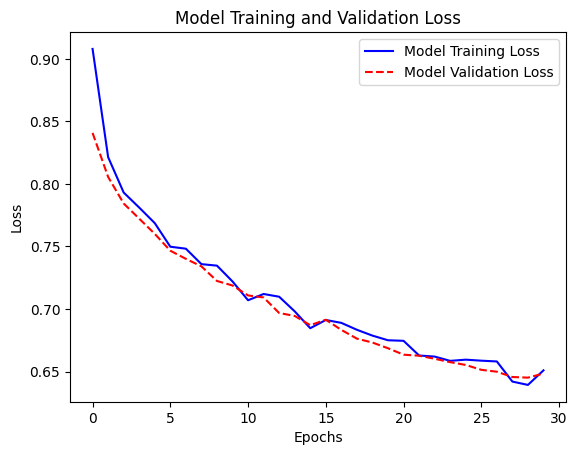

In [14]:
# 학습 결과 시각화
Loss_Visualization(train_losses_SH, val_losses_SH)

In [15]:
kp_names = [
    "0_right_ankle",      # 오른쪽 발목
    "1_right_knee",       # 오른쪽 무릎
    "2_right_hip",        # 오른쪽 엉덩이
    "3_left_hip",         # 왼쪽 엉덩이
    "4_left_knee",        # 왼쪽 무릎
    "5_left_ankle",       # 왼쪽 발목
    "6_pelvis",           # 골반
    "7_chest",            # 가슴(흉부)
    "8_neck",             # 목
    "9_head_top",         # 머리 위
    "10_right_wrist",     # 오른쪽 손목
    "11_right_elbow",     # 오른쪽 팔꿈치
    "12_right_shoulder",  # 오른쪽 어깨
    "13_left_shoulder",   # 왼쪽 어깨
    "14_left_elbow",      # 왼쪽 팔꿈치
    "15_left_wrist",      # 왼쪽 손목
]
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [16]:
agg_list = []
epoch_dist_train_SH = pd.DataFrame(columns = kp_names)
for i in range(EPOCH):
    t_list=train_recode_SH.loc[f'epoch{i+1}', 'distance']
    N = len(t_list)
    mean_per_pos_per_epoch = sum(t for t in t_list) / N
    epoch_dist_train_SH.loc[f'epoch{i+1}'] = mean_per_pos_per_epoch.numpy()
    agg_list.extend(t_list)
    
N = len(agg_list)
mean_per_pos = sum(t for t in agg_list) / N
print(mean_per_pos)

tensor([0.4282, 0.4317, 0.3175, 0.3240, 0.4392, 0.4455, 0.3264, 0.0786, 0.0762,
        0.1027, 0.2419, 0.2084, 0.1461, 0.1439, 0.2041, 0.2337])


In [17]:
agg_list = []
epoch_dist_val_SH = pd.DataFrame(columns = kp_names)
for i in range(EPOCH):
    t_list=val_recode_SH.loc[f'epoch{i+1}', 'distance']
    N = len(t_list)
    mean_per_pos_per_epoch = sum(t for t in t_list) / N
    epoch_dist_val_SH.loc[f'epoch{i+1}'] = mean_per_pos_per_epoch.numpy()
    agg_list.extend(t_list)
    
N = len(agg_list)
mean_per_pos = sum(t for t in agg_list) / N
print(mean_per_pos)

tensor([0.4270, 0.4213, 0.3080, 0.3100, 0.4253, 0.4400, 0.3157, 0.0719, 0.0707,
        0.0936, 0.2355, 0.2006, 0.1425, 0.1387, 0.1970, 0.2322])


# Tabel 1)

In [18]:
display(epoch_dist_train_SH)

,0_right_ankle,1_right_knee,2_right_hip,3_left_hip,4_left_knee,5_left_ankle,6_pelvis,7_chest,8_neck,9_head_top,10_right_wrist,11_right_elbow,12_right_shoulder,13_left_shoulder,14_left_elbow,15_left_wrist
epoch1,0.447801,0.318561,0.240682,0.244410,0.350607,0.483495,0.241030,0.185746,0.186274,0.207829,0.296256,0.248659,0.212804,0.217113,0.263664,0.287461
epoch2,0.401889,0.288362,0.204517,0.202224,0.305084,0.431227,0.195507,0.125184,0.123412,0.150945,0.242212,0.215736,0.164396,0.162389,0.220534,0.251267
epoch3,0.435984,0.295647,0.199452,0.192339,0.319238,0.455541,0.186428,0.108892,0.102854,0.131008,0.237727,0.201772,0.156605,0.152319,0.219949,0.245276
epoch4,0.457584,0.282974,0.178785,0.175659,0.314771,0.500415,0.167357,0.111721,0.112860,0.135026,0.258161,0.215562,0.155888,0.171176,0.242332,0.269874
epoch5,0.669943,0.547100,0.183472,0.181016,0.581413,0.704717,0.185198,0.099877,0.094426,0.121868,0.241424,0.209521,0.160002,0.150681,0.216936,0.240138
epoch6,0.648085,0.671772,0.174499,0.174152,0.704499,0.676120,0.161223,0.094761,0.089836,0.121629,0.246078,0.220057,0.156973,0.160777,0.210902,0.241642
epoch7,0.681531,0.689296,0.401639,0.276501,0.730186,0.691621,0.414829,0.090553,0.083331,0.123824,0.245790,0.216567,0.146094,0.169602,0.214451,0.242922
epoch8,0.646847,0.664253,0.314455,0.300676,0.679428,0.665313,0.388464,0.085108,0.080463,0.108283,0.246813,0.216387,0.155940,0.159290,0.213421,0.259441
epoch9,0.575230,0.609341,0.294770,0.364468,0.613708,0.604877,0.385003,0.080990,0.075106,0.099871,0.258328,0.210863,0.153875,0.142196,0.200673,0.234677
epoch10,0.519403,0.577268,0.290524,0.320832,0.544235,0.530715,0.376579,0.089136,0.084384,0.112418,0.238028,0.226917,0.144713,0.153717,0.206089,0.229467


# Tabel 2)

In [19]:
display(epoch_dist_val_SH)

,0_right_ankle,1_right_knee,2_right_hip,3_left_hip,4_left_knee,5_left_ankle,6_pelvis,7_chest,8_neck,9_head_top,10_right_wrist,11_right_elbow,12_right_shoulder,13_left_shoulder,14_left_elbow,15_left_wrist
epoch1,0.399353,0.273831,0.184271,0.184775,0.297569,0.420466,0.183658,0.124000,0.122510,0.140346,0.231787,0.197490,0.160904,0.154952,0.205355,0.235603
epoch2,0.405287,0.279121,0.204211,0.190026,0.281230,0.414917,0.184309,0.118070,0.115159,0.134861,0.248553,0.209231,0.158286,0.157556,0.225859,0.250671
epoch3,0.405360,0.265805,0.173279,0.174769,0.285782,0.406790,0.162044,0.099330,0.100354,0.132056,0.258388,0.203956,0.149001,0.148853,0.210101,0.237539
epoch4,0.649147,0.314257,0.178311,0.185572,0.313329,0.682450,0.169989,0.098290,0.095130,0.128144,0.283491,0.222943,0.155333,0.155847,0.236813,0.286950
epoch5,0.669078,0.678964,0.172101,0.169419,0.656596,0.695809,0.161227,0.096987,0.094032,0.110274,0.264160,0.219666,0.176951,0.161991,0.220811,0.257340
epoch6,0.670021,0.705764,0.156775,0.158395,0.737495,0.700250,0.142456,0.082457,0.076648,0.102418,0.256236,0.230842,0.144579,0.167049,0.213710,0.257512
epoch7,0.677460,0.706334,0.360087,0.173405,0.735439,0.704595,0.387069,0.078665,0.076188,0.100840,0.239755,0.198392,0.153078,0.152999,0.205845,0.238525
epoch8,0.673511,0.702656,0.364717,0.479469,0.729850,0.702956,0.524202,0.079754,0.074066,0.100572,0.236353,0.218862,0.153218,0.141472,0.192625,0.232761
epoch9,0.628956,0.654534,0.307029,0.400215,0.618094,0.661088,0.391625,0.075203,0.070591,0.094245,0.244011,0.221765,0.149127,0.133557,0.204179,0.247387
epoch10,0.603526,0.675279,0.578854,0.502628,0.661479,0.640857,0.548582,0.074095,0.074971,0.098824,0.264131,0.210065,0.148489,0.134247,0.191805,0.246887


In [20]:
best_model_file_SB, train_losses_SB, val_losses_SB, train_recode_SB, val_recode_SB = train(model=SimpleBaseline, epochs=EPOCH, learning_rate=LR, num_heatmap=NUM_HEATMAP,
                                                                           batch_size=BATCH_SIZE, train_annotation_file=TRAIN_JSON, 
                                                                           val_annotation_file=VALID_JSON, image_dir=IMAGE_PATH, isSave=False,
                                                                           scheduler=SCHEDULER, warmup_steps=WARMUP_STEPS,patience=PANTIENCE, num_workers=NUM_WORKERS)

단일 GPU 혹은 CPU 사용
Start training...
Start epoch 1 with learning rate 0.001000


100%|██████████| 22/22 [00:19<00:00,  1.14it/s]


Epoch 1 train loss 0.9058
Epoch 1 val loss 0.8502
Model E:\AIFFEL\Data\mpii\models\model-epoch-1-loss-0.8502.pt saved.
Start epoch 2 with learning rate 0.001000


100%|██████████| 22/22 [00:19<00:00,  1.13it/s]


Epoch 2 train loss 0.8371
Epoch 2 val loss 0.8296
Model E:\AIFFEL\Data\mpii\models\model-epoch-2-loss-0.8296.pt saved.
Start epoch 3 with learning rate 0.001000


100%|██████████| 22/22 [00:19<00:00,  1.12it/s]


Epoch 3 train loss 0.8164
Epoch 3 val loss 0.8077
Model E:\AIFFEL\Data\mpii\models\model-epoch-3-loss-0.8077.pt saved.
Start epoch 4 with learning rate 0.001000


100%|██████████| 22/22 [00:19<00:00,  1.11it/s]


Epoch 4 train loss 0.8060
Epoch 4 val loss 0.7975
Model E:\AIFFEL\Data\mpii\models\model-epoch-4-loss-0.7975.pt saved.
Start epoch 5 with learning rate 0.001000


100%|██████████| 22/22 [00:19<00:00,  1.15it/s]


Epoch 5 train loss 0.7983
Epoch 5 val loss 0.7886
Model E:\AIFFEL\Data\mpii\models\model-epoch-5-loss-0.7886.pt saved.
Start epoch 6 with learning rate 0.001000


100%|██████████| 22/22 [00:19<00:00,  1.13it/s]


Epoch 6 train loss 0.7871
Epoch 6 val loss 0.7830
Model E:\AIFFEL\Data\mpii\models\model-epoch-6-loss-0.7830.pt saved.
Start epoch 7 with learning rate 0.001000


100%|██████████| 22/22 [00:19<00:00,  1.13it/s]


Epoch 7 train loss 0.7808
Epoch 7 val loss 0.7770
Model E:\AIFFEL\Data\mpii\models\model-epoch-7-loss-0.7770.pt saved.
Start epoch 8 with learning rate 0.001000


100%|██████████| 22/22 [00:18<00:00,  1.16it/s]


Epoch 8 train loss 0.7751
Epoch 8 val loss 0.7690
Model E:\AIFFEL\Data\mpii\models\model-epoch-8-loss-0.7690.pt saved.
Start epoch 9 with learning rate 0.001000


100%|██████████| 22/22 [00:19<00:00,  1.13it/s]


Epoch 9 train loss 0.7684
Epoch 9 val loss 0.7595
Model E:\AIFFEL\Data\mpii\models\model-epoch-9-loss-0.7595.pt saved.
Start epoch 10 with learning rate 0.001000


100%|██████████| 22/22 [00:19<00:00,  1.13it/s]


Epoch 10 train loss 0.7678
Epoch 10 val loss 0.7550
Model E:\AIFFEL\Data\mpii\models\model-epoch-10-loss-0.7550.pt saved.
Start epoch 11 with learning rate 0.001000


100%|██████████| 22/22 [00:18<00:00,  1.18it/s]


Epoch 11 train loss 0.7569
Epoch 11 val loss 0.7493
Model E:\AIFFEL\Data\mpii\models\model-epoch-11-loss-0.7493.pt saved.
Start epoch 12 with learning rate 0.001000


100%|██████████| 22/22 [00:18<00:00,  1.20it/s]


Epoch 12 train loss 0.7506
Epoch 12 val loss 0.7450
Model E:\AIFFEL\Data\mpii\models\model-epoch-12-loss-0.7450.pt saved.
Start epoch 13 with learning rate 0.001000


100%|██████████| 22/22 [00:18<00:00,  1.16it/s]


Epoch 13 train loss 0.7421
Epoch 13 val loss 0.7443
Model E:\AIFFEL\Data\mpii\models\model-epoch-13-loss-0.7443.pt saved.
Start epoch 14 with learning rate 0.001000


100%|██████████| 22/22 [00:18<00:00,  1.18it/s]


Epoch 14 train loss 0.7481
Epoch 14 val loss 0.7413
Model E:\AIFFEL\Data\mpii\models\model-epoch-14-loss-0.7413.pt saved.
Start epoch 15 with learning rate 0.001000


100%|██████████| 22/22 [00:18<00:00,  1.20it/s]


Epoch 15 train loss 0.7400
Epoch 15 val loss 0.7436
Start epoch 16 with learning rate 0.001000


100%|██████████| 22/22 [00:19<00:00,  1.15it/s]


Epoch 16 train loss 0.7381
Epoch 16 val loss 0.7296
Model E:\AIFFEL\Data\mpii\models\model-epoch-16-loss-0.7296.pt saved.
Start epoch 17 with learning rate 0.001000


100%|██████████| 22/22 [00:18<00:00,  1.20it/s]


Epoch 17 train loss 0.7386
Epoch 17 val loss 0.7283
Model E:\AIFFEL\Data\mpii\models\model-epoch-17-loss-0.7283.pt saved.
Start epoch 18 with learning rate 0.001000


100%|██████████| 22/22 [00:18<00:00,  1.21it/s]


Epoch 18 train loss 0.7333
Epoch 18 val loss 0.7215
Model E:\AIFFEL\Data\mpii\models\model-epoch-18-loss-0.7215.pt saved.
Start epoch 19 with learning rate 0.001000


100%|██████████| 22/22 [00:18<00:00,  1.19it/s]


Epoch 19 train loss 0.7277
Epoch 19 val loss 0.7201
Model E:\AIFFEL\Data\mpii\models\model-epoch-19-loss-0.7201.pt saved.
Start epoch 20 with learning rate 0.001000


100%|██████████| 22/22 [00:18<00:00,  1.16it/s]


Epoch 20 train loss 0.7240
Epoch 20 val loss 0.7164
Model E:\AIFFEL\Data\mpii\models\model-epoch-20-loss-0.7164.pt saved.
Start epoch 21 with learning rate 0.001000


100%|██████████| 22/22 [00:18<00:00,  1.19it/s]


Epoch 21 train loss 0.7196
Epoch 21 val loss 0.7120
Model E:\AIFFEL\Data\mpii\models\model-epoch-21-loss-0.7120.pt saved.
Start epoch 22 with learning rate 0.001000


100%|██████████| 22/22 [00:18<00:00,  1.18it/s]


Epoch 22 train loss 0.7149
Epoch 22 val loss 0.7080
Model E:\AIFFEL\Data\mpii\models\model-epoch-22-loss-0.7080.pt saved.
Start epoch 23 with learning rate 0.001000


100%|██████████| 22/22 [00:18<00:00,  1.17it/s]


Epoch 23 train loss 0.7165
Epoch 23 val loss 0.7062
Model E:\AIFFEL\Data\mpii\models\model-epoch-23-loss-0.7062.pt saved.
Start epoch 24 with learning rate 0.001000


100%|██████████| 22/22 [00:18<00:00,  1.18it/s]


Epoch 24 train loss 0.7082
Epoch 24 val loss 0.7064
Start epoch 25 with learning rate 0.001000


100%|██████████| 22/22 [00:18<00:00,  1.20it/s]


Epoch 25 train loss 0.7071
Epoch 25 val loss 0.7031
Model E:\AIFFEL\Data\mpii\models\model-epoch-25-loss-0.7031.pt saved.
Start epoch 26 with learning rate 0.001000


100%|██████████| 22/22 [00:17<00:00,  1.23it/s]


Epoch 26 train loss 0.7065
Epoch 26 val loss 0.7050
Start epoch 27 with learning rate 0.001000


100%|██████████| 22/22 [00:18<00:00,  1.22it/s]


Epoch 27 train loss 0.7060
Epoch 27 val loss 0.6980
Model E:\AIFFEL\Data\mpii\models\model-epoch-27-loss-0.6980.pt saved.
Start epoch 28 with learning rate 0.001000


100%|██████████| 22/22 [00:18<00:00,  1.21it/s]


Epoch 28 train loss 0.7021
Epoch 28 val loss 0.6944
Model E:\AIFFEL\Data\mpii\models\model-epoch-28-loss-0.6944.pt saved.
Start epoch 29 with learning rate 0.001000


100%|██████████| 22/22 [00:17<00:00,  1.22it/s]


Epoch 29 train loss 0.6993
Epoch 29 val loss 0.6908
Model E:\AIFFEL\Data\mpii\models\model-epoch-29-loss-0.6908.pt saved.
Start epoch 30 with learning rate 0.001000


100%|██████████| 22/22 [00:17<00:00,  1.25it/s]


Epoch 30 train loss 0.6977
Epoch 30 val loss 0.6918


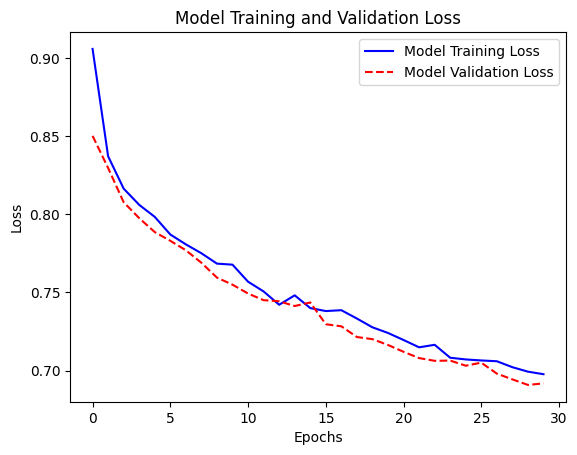

In [21]:
# 학습 결과 시각화
Loss_Visualization(train_losses_SB, val_losses_SB)

In [22]:
agg_list = []
epoch_dist_train_SB = pd.DataFrame(columns = kp_names)
for i in range(EPOCH):
    t_list=train_recode_SB.loc[f'epoch{i+1}', 'distance']
    N = len(t_list)
    mean_per_pos_per_epoch = sum(t for t in t_list) / N
    epoch_dist_train_SB.loc[f'epoch{i+1}'] = mean_per_pos_per_epoch.numpy()
    agg_list.extend(t_list)
    
N = len(agg_list)
mean_per_pos = sum(t for t in agg_list) / N
print(mean_per_pos)

tensor([0.6164, 0.6004, 0.4882, 0.3700, 0.6289, 0.6332, 0.4387, 0.1044, 0.1031,
        0.1285, 0.2546, 0.2318, 0.1646, 0.1622, 0.2310, 0.2518])


In [23]:
agg_list = []
epoch_dist_val_SB = pd.DataFrame(columns = kp_names)
for i in range(EPOCH):
    t_list=val_recode_SB.loc[f'epoch{i+1}', 'distance']
    N = len(t_list)
    mean_per_pos_per_epoch = sum(t for t in t_list) / N
    epoch_dist_val_SB.loc[f'epoch{i+1}'] = mean_per_pos_per_epoch.numpy()
    agg_list.extend(t_list)
    
N = len(agg_list)
mean_per_pos = sum(t for t in agg_list) / N
print(mean_per_pos)

tensor([0.6197, 0.6122, 0.4742, 0.3805, 0.6411, 0.6418, 0.4230, 0.0950, 0.0939,
        0.1169, 0.2484, 0.2275, 0.1591, 0.1559, 0.2247, 0.2476])


# Tabel 3)

In [24]:
display(epoch_dist_train_SB)

,0_right_ankle,1_right_knee,2_right_hip,3_left_hip,4_left_knee,5_left_ankle,6_pelvis,7_chest,8_neck,9_head_top,10_right_wrist,11_right_elbow,12_right_shoulder,13_left_shoulder,14_left_elbow,15_left_wrist
epoch1,0.509461,0.386809,0.281330,0.263859,0.367321,0.495401,0.270708,0.257080,0.275256,0.385293,0.312999,0.297674,0.287609,0.277312,0.281145,0.299947
epoch2,0.500678,0.383179,0.274313,0.268370,0.378558,0.508129,0.258049,0.209486,0.221240,0.183593,0.276594,0.261470,0.243224,0.234770,0.252513,0.274227
epoch3,0.453968,0.354891,0.263397,0.256614,0.342973,0.456418,0.245236,0.188832,0.184290,0.151746,0.294749,0.268962,0.209590,0.207008,0.259671,0.286963
epoch4,0.440971,0.324051,0.228114,0.215312,0.319331,0.431820,0.207479,0.144369,0.141504,0.158873,0.267537,0.251244,0.179736,0.173473,0.242589,0.259277
epoch5,0.434646,0.322809,0.220812,0.198711,0.322006,0.443139,0.195523,0.115545,0.116350,0.139643,0.270332,0.245878,0.174191,0.155176,0.237107,0.243659
epoch6,0.431572,0.304768,0.210613,0.195612,0.312263,0.434260,0.187016,0.118699,0.123038,0.140230,0.253659,0.240200,0.171852,0.154501,0.240309,0.250926
epoch7,0.455088,0.318142,0.212483,0.197305,0.311334,0.453328,0.187166,0.114978,0.112356,0.126503,0.258685,0.237192,0.169082,0.163495,0.248850,0.253399
epoch8,0.456732,0.340132,0.199632,0.188741,0.349063,0.461711,0.172995,0.117116,0.122118,0.134790,0.261311,0.231936,0.166591,0.159187,0.244512,0.256181
epoch9,0.694257,0.654195,0.196466,0.182204,0.725493,0.716136,0.166442,0.103787,0.103633,0.132750,0.254095,0.226687,0.152619,0.152628,0.225152,0.247982
epoch10,0.662044,0.699236,0.196061,0.173253,0.751913,0.682073,0.241639,0.098442,0.095603,0.120721,0.260740,0.286128,0.156966,0.154019,0.224899,0.256025


# Tabel 4)

In [25]:
display(epoch_dist_val_SB)

,0_right_ankle,1_right_knee,2_right_hip,3_left_hip,4_left_knee,5_left_ankle,6_pelvis,7_chest,8_neck,9_head_top,10_right_wrist,11_right_elbow,12_right_shoulder,13_left_shoulder,14_left_elbow,15_left_wrist
epoch1,0.492737,0.372149,0.266477,0.259590,0.372416,0.498350,0.252448,0.207523,0.231564,0.328004,0.287307,0.264649,0.251228,0.241341,0.261318,0.280850
epoch2,0.445807,0.357632,0.257330,0.248288,0.344269,0.478102,0.232473,0.217953,0.238140,0.148341,0.277590,0.256697,0.238486,0.223404,0.246228,0.258140
epoch3,0.408018,0.307068,0.240259,0.219307,0.302035,0.407845,0.214046,0.126875,0.124899,0.133503,0.276426,0.251443,0.168066,0.170709,0.240955,0.270006
epoch4,0.408157,0.309839,0.212727,0.210774,0.310029,0.410806,0.202681,0.113157,0.109170,0.141577,0.259192,0.243871,0.169046,0.155788,0.235599,0.248397
epoch5,0.416769,0.313551,0.213413,0.188156,0.302313,0.408362,0.184515,0.122177,0.125509,0.136488,0.257547,0.243559,0.169805,0.158912,0.225725,0.234578
epoch6,0.417977,0.296886,0.200697,0.184009,0.298499,0.420100,0.181090,0.107372,0.108625,0.123412,0.243297,0.223786,0.165719,0.147204,0.231428,0.234744
epoch7,0.431693,0.308747,0.188415,0.176858,0.307498,0.434924,0.163525,0.111620,0.111568,0.119864,0.255618,0.222416,0.170033,0.148820,0.241003,0.256743
epoch8,0.667792,0.568603,0.181808,0.174856,0.714655,0.686172,0.156198,0.098285,0.097635,0.118777,0.260471,0.232926,0.156178,0.146056,0.238346,0.266675
epoch9,0.677431,0.706903,0.178330,0.162334,0.740925,0.704960,0.156055,0.101214,0.098429,0.116375,0.240960,0.213412,0.149829,0.142134,0.223767,0.246094
epoch10,0.677431,0.706903,0.202863,0.168007,0.740925,0.705577,0.192071,0.096305,0.088388,0.114950,0.251769,0.366177,0.156766,0.158879,0.241934,0.269415


In [26]:
image_paths = {"cartoon":['Panty_Anarchy.webp','Stocking_Anarchy.webp','Simpsons_Family.png','Homer_Simpson.png','rick_and_morty.jpg','Hazbin_Hotel.webp'],
              "anime":['Panty_Anarchy_moe.webp', 'Stocking_Anarchy_moe.webp','Reze.webp','Reze2.png','Reze3.png','Faye_Valentine.webp','Faye_Valentine2.png'
                       ,'Oshi_no_Ko_My_Star.webp','Oshi_no_Ko_My_Star2.webp'],
              "manga":['Ruby_Hoshino.webp','Ai_Hoshino.webp','Kimetsu_no_Yaiba.webp'],
              "figure":['Stocking_Anarchy_figure.jpg','Panty_Anarchy_figure.jpg','Asuma_Toki.jpg','Kosaka_Wakamo.png','genshin_impact.jpeg'],
              "game_subculture_3d":['Furina1.png','Furina2.png','Augusta1.png','Augusta2.png','mavuika.webp','genshin_impact2.jpg'],
              "PIXAR":['joy.webp','Riley_Andersen.webp','Miguel_Rivera.webp','Woody.webp','soul.webp','coco_family.webp'],
              "game_3d":['Ninave.png','Echidna.png','Abrelshud.webp','lost_ark.jpg','lost_ark2.jpg','Rainbow_Six_Siege_X.webp'],
              "celebrities_asian":['Chaewon.webp','IVE_Wonyoung.jpg','Karina.jpg','Choi_Min_Soo.webp','Won_Bin.jpg','LE_SSERAFIM.webp','BLACKPINK.webp','BTS.webp'],
              "celebrities_westerner":['Joker.webp','Margot_Elise_Robbie.webp','Emma_Charlotte_Duerre_Watson.png','Timothée_Chalamet.png',
                                       'The_Lord_of_the_Rings.webp','Oppenheimer.jpg','Oppenheimer_Neumann.jpg']}
home_dir = "C:/Users/USER/Desktop/AIFFEL/work/img"

In [ ]:
for path in image_paths["cartoon"]:
    test_image = os.path.join(home_dir, path)
    image, keypoints = predict(best_model_file_SH, test_image)
    draw_keypoints_on_image(image, keypoints)
    draw_skeleton_on_image(image, keypoints)

In [ ]:
for path in image_paths["anime"]:
    test_image = os.path.join(home_dir, path)
    image, keypoints = predict(best_model_file_SH, test_image)
    draw_keypoints_on_image(image, keypoints)
    draw_skeleton_on_image(image, keypoints)

In [ ]:
for path in image_paths["manga"]:
    test_image = os.path.join(home_dir, path)
    image, keypoints = predict(best_model_file_SH, test_image)
    draw_keypoints_on_image(image, keypoints)
    draw_skeleton_on_image(image, keypoints)

In [ ]:
for path in image_paths["figure"]:
    test_image = os.path.join(home_dir, path)
    image, keypoints = predict(best_model_file_SH, test_image)
    draw_keypoints_on_image(image, keypoints)
    draw_skeleton_on_image(image, keypoints)

In [ ]:
for path in image_paths["game_subculture_3d"]:
    test_image = os.path.join(home_dir, path)
    image, keypoints = predict(best_model_file_SH, test_image)
    draw_keypoints_on_image(image, keypoints)
    draw_skeleton_on_image(image, keypoints)

In [ ]:
for path in image_paths["PIXAR"]:
    test_image = os.path.join(home_dir, path)
    image, keypoints = predict(best_model_file_SH, test_image)
    draw_keypoints_on_image(image, keypoints)
    draw_skeleton_on_image(image, keypoints)

In [ ]:
for path in image_paths["game_3d"]:
    test_image = os.path.join(home_dir, path)
    image, keypoints = predict(best_model_file_SH, test_image)
    draw_keypoints_on_image(image, keypoints)
    draw_skeleton_on_image(image, keypoints)

In [ ]:
for path in image_paths["celebrities_asian"]:
    test_image = os.path.join(home_dir, path)
    image, keypoints = predict(best_model_file_SH, test_image)
    draw_keypoints_on_image(image, keypoints)
    draw_skeleton_on_image(image, keypoints)

In [ ]:
for path in image_paths["celebrities_westerner"]:
    test_image = os.path.join(home_dir, path)
    image, keypoints = predict(best_model_file_SH, test_image)
    draw_keypoints_on_image(image, keypoints)
    draw_skeleton_on_image(image, keypoints)

Pose Estimation은 2D 또는 3D 공간에서 사람의 관절(joint) 위치를 좌표 형태로 추정하는 기술로, 단일 이미지 혹은 영상 프레임에서 스켈레톤(skeleton)을 복원하는 것을 목표로 합니다. 게임과 영화 산업의 3D 애니메이션, 모션 캡쳐 후처리, 가상 캐릭터 리깅(rigging), 동작 인식(HAR), 스포츠 분석, 재활 및 헬스케어 등 다양한 응용 분야에서 핵심 기반 기술로 활용되고 있기 때문에, 관절 위치를 얼마나 정확하고 안정적으로 예측하느냐가 곧 서비스 품질과 직결됩니다. 특히 3D 애니메이션 pipliune에서는 frame마다 수많은 관절 정보를 자동으로 생성해야 하므로, Pose Estimation 모델의 성능은 제작 비용과 작업 시간 측면에서 매우 중요한 요소입니다.

본 실험에서는 동일한 dataset과 학습 환경에서 대표적인 heatmap 기반 2D Pose Estimation 구조인 StackedHourglassNetwork와 SimpleBaseline 두 가지 모델을 비교,분석하였습니다

# 결과

두 모델을 30 epoch 까지 학습시킨 결과는 다음과 같습니다.

- StackedHourglassNetwork

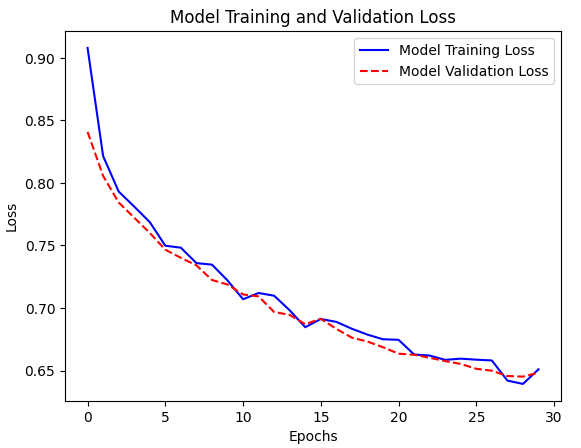

- SimpleBaseline

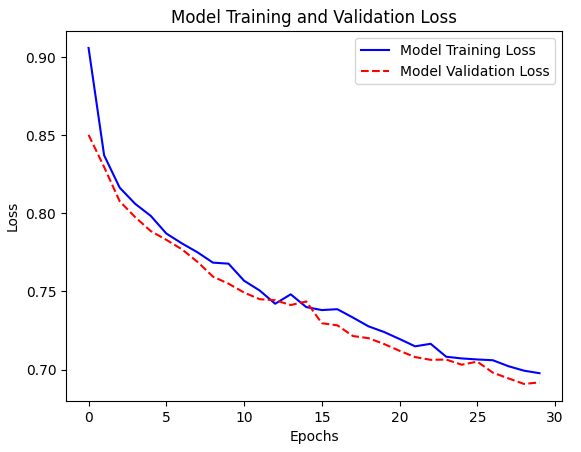

두 모델 모두 학습이 되는 모습을 그래프를 통하여 관측할 수 있었지만 overfitting 경향성이 나타나지 않아서 추가적으로 학습이 가능하다고 생각합니다. 따라서, 해당 경향성을 알아보기 위하여 추가적으로 learning rate를 높이거나 epoch를 높혀 실험해 봐야 한다고 생각합니다.

그래프에서 보았던 것과 같이 overfitting의 경향성이 약함으로 30epoch에서 두 모델의 loss를 비교했을 때는 아래와 같습니다.

|model|Train Loss|Validation Loss|
|-----|--------|--------|
|StackedHourglassNetwork|0.6509|0.6484|
|SimpleBaseline|0.6977|0.6918|

이는 두 모델의 실제 성능차이를 나타낸다고 보기보다는 수렴 속도가 StackedHourglassNetwork에서 더 빠르게 된다고 생각하는게 타당하다고 생각합니다. 두 모델 전부 overfitting 경향성이 나타나지 않았기 때문입니다. 또한, 모델이 StackedHourglass가 더 복잡하기 때문에 수렴속도가 더 늦을 것이라고 초기에 예측하였지만 그와 반대로 StackedHourglass가 더욱 빠른 것으로 보아 skip connection이 수렴속도를 높여주었다고 예측합니다. 두 모델이 skip connection만 차이가 있는 것이 아니기 때문에 정확한 비교는 어려우나 두 모델의 가장 큰 특징 중 하나가 skip connection의 유무와 upsampling 등의 과정이기 때문에 모델의 최적화과 관련이 있는 skip conneciont이 더 큰 기여를 했을 것이라 예측합니다.

두 모델이 예측한 joint와 label과의 거리를 계산하여 평균을 내었을 때 흥미로운 사실을 발견할 수 있습니다. 결과는 아래와 같습니다.

|model|0_right_ankle|1_right_knee|2_right_hip|3_left_hip|4_left_knee|5_left_ankle|6_pelvis|7_chest|8_neck|9_head_top|10_right_wrist|11_right_elbow|12_right_shoulder|13_left_shoulder|14_left_elbow|15_left_wrist|
|-----|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
|StackedHourglassNetwork|0.4270|0.4213|0.3080|0.3100|0.4253|0.4400|0.3157|0.0719|0.0707|0.0936|0.2355|0.2006|0.1425|0.1387|0.1970|0.2322|
|SimpleBaseline|0.6197|0.6122|0.4742|0.3805|0.6411|0.6418|0.4230|0.0950|0.0939|0.1169|0.2484|0.2275|0.1591|0.1559|0.2247|0.2476|

같은 dataset으로 학습하였음에도 불구하고 두 모델이 더 잘 예측하는 joint와 예측하지 못하는 joint가 달랐습니다. 예를 들어, StackedHourglassNetwork 는 10_right_wrist를 거리가 0.1에 가까울 정도로 잘 예측하였으나, 반대로 SimpleBaseline은 거리가 0.25에 가까운 값으로 상대적으로 좋은 예측을 보여주지 못하였습니다. 정 반대의 예시도 존재하였는데, 7_chest joint는 SimpleBaseline이 0.0950, StackedHourglassNetwork이 0.3157로 SimpleBaseline이 더 잘 예측하는 모습을 보여주었습니다.

두 모델 모두 잘 예측하지 못한 joint는 0_right_ankle, 1_right_knee 등이 있지만 SimpleBaseline이 조금 더 안정되지 못한 모습을 보여주었습니다.

두 모델이 학습과정에서 joint 별로 label과의 거리가 어떻게 변하였는지 알아보기 위하여 tabel 1, tabel 2, tabel 3, tabel 4 를 작성하였습니다. 각 tabel은 epoch 별로 StackedHourglassNetwork train mean distances, StackedHourglassNetwork validation mean distances, SimpleBaseline train mean distances, SimpleBaseline validation mean distances을 의미합니다.

Tabel 1과 tabel 2를 보면 잘 예측하지 못하는 0_right_ankle, 1_right_knee joint의 경우 초반과 후반에서 측정한 거리가 큰 차이가 없다는 것을 알 수 있습니다. 반면, 3_left_hip는 오히려 label과의 거리가 증가하였습니다. 8_neck, 9_head_top과 같이 학습이 잘 된 joint의 경우는 처음부터 마지막까지 거리가 줄어드는 것을 볼 수 있습니다. 높은 확률로 해당 joint들이 loss 감소에 크게 기여했다고 볼 수 있습니다. 

Tabel 3과 tabel 4도 마찬가지로 잘 예측하지 못하는 0_right_ankle, 1_right_knee joint의 경우 점점 거리가 증가하는 것을 볼 수 있습니다. 10_right_wrist나 11_right_elbow 과 같이 초반과 후반이 차이가 거의 없는 joint 들도 있었으나 전반적으로 tabel 1과 tabel 2에서 나타난 경향성에 비해 조금 더 빠르게 증가하는 경향성이 나타났습니다. 

전체적으로 tabel 1, tabel 2, tabel 3, tabel 4 를 참고해 보면 joint가 항상 등장하지 않는 경우에 대해서 학습을 잘 못하는 경향성이 있다고 예측되기 때문에 해당 부분에 대해서 추가적인 실험이 필요합니다.

추가적으로 style에 따른 예측을 실험해 보려고 했으나 시간이 부족하여 코드만 완성해 놓았습니다.